In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from pandas.plotting import lag_plot

df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)
df = df.drop('EwsProcedure', 1)
df.ObservationDate = pd.to_datetime(arg=df.ObservationDate,infer_datetime_format=True)

In [2]:
patient = 1199
subdf = df[df['PatientId'] == patient]
subdf = subdf.reset_index(drop=True)

In [3]:
subdf.head()

,PatientId,ObservationDate,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
0,1199,2019-06-05 12:22:09,2,124.0,0.0,ALERT,0,96.0,0.0,True,2.0,86,0,19,0,37.0,0
1,1199,2019-06-05 17:41:18,3,101.0,1.0,ALERT,0,97.0,0.0,True,2.0,83,0,18,0,36.7,0
2,1199,2019-06-06 06:51:03,3,118.0,0.0,ALERT,0,95.0,1.0,True,2.0,90,0,19,0,37.0,0
3,1199,2019-06-06 11:43:05,4,107.0,1.0,ALERT,0,92.0,2.0,False,0.0,92,1,19,0,36.9,0
4,1199,2019-06-06 17:47:44,4,109.0,1.0,ALERT,0,95.0,1.0,True,2.0,79,0,18,0,37.0,0


In [4]:
# print(subdf.HR.sort_values().unique()) #show unique values of column sorted

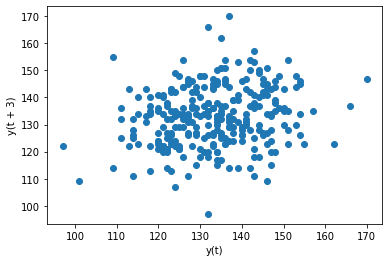

In [5]:
lag_plot(subdf.SBP,lag=3)   #observation vs previous observation
plt.show()

In [20]:
series = subdf.SBP
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.330677
t+1  0.330677  1.000000


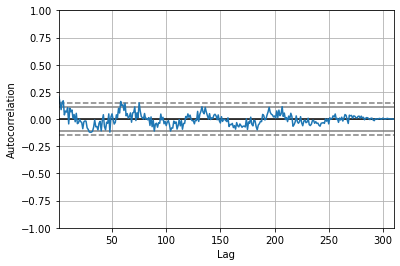

In [36]:
from pandas.plotting import autocorrelation_plot
plt.figure
autocorrelation_plot(subdf.HR)

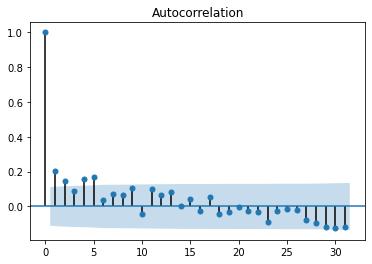

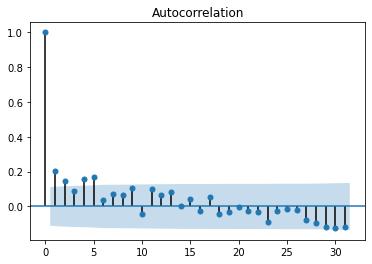

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(subdf.HR, lags=31)


Test MSE: 157.714


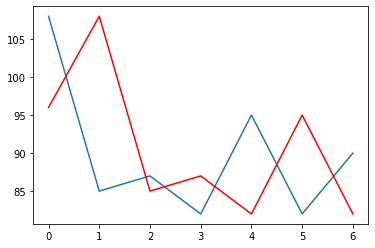

In [41]:
#The expected values for the next 7 measurements are plotted (blue) compared to the predictions from the model (red).

from sklearn.metrics import mean_squared_error
series = subdf.HR
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
	return x
 
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

Coefficients: [ 6.67220221e+01  1.69409126e-01  6.18250219e-02  1.95489927e-02
  6.28993240e-02  1.68805943e-01 -8.00485133e-02  1.86629517e-02
 -4.16148408e-03  6.90570395e-02 -1.61795193e-01  1.21635626e-01
  4.59148033e-02  4.26716221e-02 -2.45846795e-02  8.69143286e-02
 -1.06860382e-01  8.82263191e-02 -7.49437934e-02 -2.33530914e-03
 -3.18532510e-02  4.00049541e-02 -4.76127815e-02 -3.97072041e-02
 -7.74399397e-03  4.54887707e-02 -3.38974515e-02  8.80678208e-03
 -5.93379865e-02 -9.51223340e-02]
predicted=91.986963, expected=108.000000
predicted=98.753757, expected=85.000000
predicted=96.880005, expected=87.000000
predicted=90.551489, expected=82.000000
predicted=95.473949, expected=95.000000
predicted=94.419036, expected=82.000000
predicted=98.474207, expected=90.000000
Test RMSE: 10.971


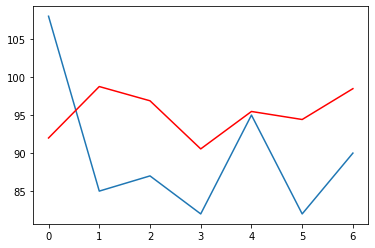

In [40]:
# Autoregression model, 7 measurement forecast

# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = subdf.HR.dropna()
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=129.735386, expected=147.000000
predicted=132.493417, expected=132.000000
predicted=131.163131, expected=128.000000
predicted=132.069741, expected=120.000000
predicted=134.172833, expected=135.000000
predicted=145.426270, expected=131.000000
predicted=133.337850, expected=136.000000
Test RMSE: 9.783


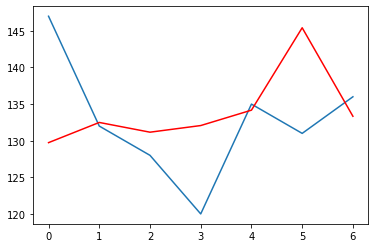

In [35]:


# create and evaluate an updated autoregressive model

from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
series = subdf.SBP.dropna()
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()